# ASTR 519 Final Project: Cannon Dataset Mining

*by Nick Konz, Henry Gu, and Roark Habegger*

## 0. CSV Creation/Data Cleaning (Roark)

In [3]:
# some of the usual imports
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# files
file1 = "allStarCannon-l31c.2.fits"
file2 = "allStar-l31c.2.fits"

hdu_list = fits.open(file1)
abun_data = Table(hdu_list[1].data)

In [4]:
#This cell takes a while because the table takes up a lot of data
hdu_list2 = fits.open(file2)
vel_data = Table(hdu_list2[1].data)

In [5]:
cols = abun_data.colnames
myCols = []
myColNames = ["RA_HRS","DEC_DEG"]
for i in range(len(cols)):
    #Ditch all the raw errors
    if not ("RAW" in str(cols[i])):
        #Get all abundances
        if ("_H" in str(cols[i])):
            myCols.append(i)
            myColNames.append(str(cols[i]))
        #Get important non-abundance values that could be useful
        elif ("TEFF" in str(cols[i])) or ("LOGG" in str(cols[i])) or ("_M" in str(cols[i])):
            myCols.append(i)
            myColNames.append(str(cols[i]))

myColNames.append('RAD_VEL')
myColNames.append('RAD_VEL_ERR')
print(myColNames)

['RA_HRS', 'DEC_DEG', 'TEFF', 'LOGG', 'M_H', 'ALPHA_M', 'FE_H', 'C_H', 'CI_H', 'N_H', 'O_H', 'NA_H', 'MG_H', 'AL_H', 'SI_H', 'P_H', 'S_H', 'K_H', 'CA_H', 'TI_H', 'TIII_H', 'V_H', 'CR_H', 'MN_H', 'CO_H', 'NI_H', 'TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR', 'FE_H_ERR', 'C_H_ERR', 'CI_H_ERR', 'N_H_ERR', 'O_H_ERR', 'NA_H_ERR', 'MG_H_ERR', 'AL_H_ERR', 'SI_H_ERR', 'P_H_ERR', 'S_H_ERR', 'K_H_ERR', 'CA_H_ERR', 'TI_H_ERR', 'TIII_H_ERR', 'V_H_ERR', 'CR_H_ERR', 'MN_H_ERR', 'CO_H_ERR', 'NI_H_ERR', 'RAD_VEL', 'RAD_VEL_ERR']


In [6]:
#Ditch entries without data
ii = (abun_data['FILENAME'] != '')

print(len(abun_data['APOGEE_ID']))
print(len(abun_data['APOGEE_ID'][ii]))
print(len(abun_data['APOGEE_ID'][ii])/len(abun_data['APOGEE_ID']))

#can parse ratios by error

277371
164074
0.5915326403985998


In [7]:
#Make array of current vals
myArr = np.array(abun_data[:][ii])
newArr = np.zeros([len(abun_data[:][ii]),len(myCols)+4],)
print(len(myArr))
print(newArr.shape)
locArr = np.array(vel_data['APOGEE_ID'][1:])
radArr = np.array(vel_data['VHELIO_AVG'][1:])
radErrArr = np.array(vel_data['VERR'][1:])

164074
(164074, 52)


In [8]:
i=0
l1=0

for i in range(len(myArr)):
    myrow = myArr[i]
    
    #Parse RA
    locStr = myrow[0]
    raStr = locStr[2:10]
    hrs = int(raStr[0:2])
    mins = int(raStr[2:4])
    secs = int(raStr[4:6])+ int(raStr[6:8])/100.0
    ra = hrs+mins/60.0+secs/3600.0

    #Parse Dec
    decStr = locStr[10:]
    if decStr[0] == "+":
        decSgn = 1.0
    else:
        decSgn = -1.0
    deg = int(decStr[1:3])*decSgn
    arcMins = int(decStr[3:5])*decSgn
    arcSecs = (int(decStr[5:7])+int(decStr[7])/10.0)*decSgn
    dec = deg+arcMins/60.0+arcSecs/3600.0


    #Save RA and Dec
    newArr[i,:2] = [ra,dec]

    ##Get Rad velocity
    ind = -1
    for l in range(l1,len(locArr)):
        if locArr[l]  == locStr:
            ind = l
            l1 = l
            break
    newArr[i,-2] = radArr[ind]
    newArr[i,-1]= radErrArr[ind]

    #Save Abundance Values
    k=0
    for j in myCols:
        colNom = myColNames[2+k]
        val=0.0
        #IF the value is bad, replace with a NaN to take up less data
        if (colNom == "NA_H_ERR"):
            valInd = 2+k-23
            if (newArr[i,valInd]<=-100.0):
                newArr[i,valInd] = np.nan
                val=np.nan
            else:
                val=myrow[j]

        if ("_ERR" in colNom) and (myrow[j] >=1) and not ("TEFF" in colNom):
            val = np.nan
            valInd = 2+k-23
            newArr[i,valInd]=np.nan

        else:
            val = myrow[j]

        newArr[i,2+k] = val
        k+=1
    perc = i/len(myArr)
    
    #Sometimes print out the fraction of data we have parsed and organized
    if int(i/20000.0) == i/20000.0:
        print(perc)



0.0
0.1218962175603691
0.2437924351207382
0.3656886526811073
0.4875848702414764
0.6094810878018455
0.7313773053622146
0.8532735229225837
0.9751697404829528


In [10]:
#Save the File to Cannon.csv with proper header
saveFile = "Cannon.csv"
headStr = ""
for entry in myColNames:
    headStr += entry
    headStr += ','
np.savetxt(saveFile,newArr,delimiter=',',fmt="%1.8e",header=headStr[:-1],comments='')

In [12]:
# Plot velocities vs. equitorial coordinates:
myArr = np.loadtxt(saveFile,delimiter=',',skiprows=1)
headArr = np.loadtxt(saveFile,delimiter=',',max_rows=1,dtype=str)
data = {}
for i in range(len(headArr)):
    data[headArr[i]] = myArr[:,i]


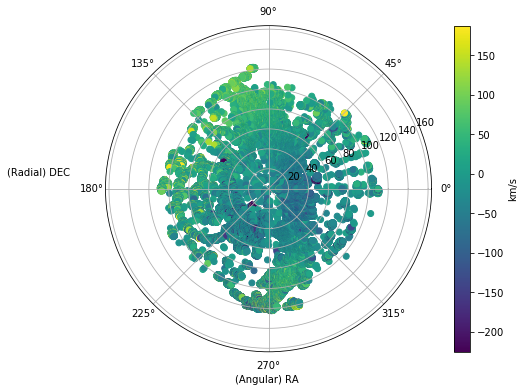

In [13]:
maxVel = np.max(np.abs(data['RAD_VEL']))

scaledVel = data['RAD_VEL']/maxVel
#plt.figure(1)
#plt.hist(scaledVel,range=[-0.24,0.2],bins=100)

th = data['RA_HRS']*2*np.pi/24.0
rad = -data['DEC_DEG']+90

fig = plt.figure(2,figsize=[8,6])
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(th, rad, c=data['RAD_VEL'], cmap='viridis',vmin=-0.24*maxVel,vmax=0.2*maxVel)

#c.colorbar(label='km/s')
ax.set_xlabel("(Angular) RA ")
ax.set_ylabel("(Radial) DEC          \n        ",rotation=0,ha='right')
fig.colorbar(c,label='km/s')
plt.show()

## 2. K-Means (Henry)

*(Henry's code/plots go here)*

## 3. GMMs and UMAP (Nick)

In [15]:
# IMPORTS #
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import LogNorm

from sklearn.mixture import GaussianMixture
import umap

### 3.1 GMMs

### 3.2 UMAP

## 4. DBSCAN (Roark)

*(Roark's code/plots go here)*